## Capstone-2023: Team-8: Stress and Effect Detection Using Wearable and Sensors Data

#### Install the following packages by uncommenting the pip install command below

* FLIRT package: This package is used to derive features associated with Accelerometer & EDA
* py-ecg-detectors: This package is used to derive ECG frequency
* mne: This package is used to derive features related to EDA sensors
* Seaborn: if not already installed in the environment

In [1]:
# !pip install flirt

In [2]:
# !pip install py-ecg-detectors

In [3]:
# !pip install mne

In [4]:
# !pip install seaborn

### Import Libraries

##### The custome python files imported below need to be uploaded to the current folder location of notebook file
* Capstone_Data_Vis_Common : contain functions for data visualizations
* Capstone_Feature_Extraction : contain functions for extracting features from the dataset
* Capstone_Data_Prep_TRAIN_TEST_SPLIT_with_survey_data : contain functions for combining individual subjects data, survey data, subject's personal data and spliting them into training and test dataset.
* Capstone_Utilities as utility : contain utilities function used in the notebook e.g. sampling data to specific sampling rate, format data to drop NaNs, inf, duplicate features in the dataset etc.

In [5]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date,datetime

import seaborn as sns
sns.set_theme()
import Capstone_Data_Vis_Common as datavis
import Capstone_Feature_Extraction as feature_extraction
import Capstone_Data_Prep_TRAIN_TEST_SPLIT_with_survey_data as dataprep
import Capstone_Utilities as utility

from scipy.signal import argrelextrema

import warnings
warnings.filterwarnings('ignore')

###### Following files are used as primary and secondary files for preparing data for analysis
* These files need to be uploaded at the path where notebook is running.

In [6]:
pickle_file_name = 'data_pkl/S'
personal_info_file_name = 'subject_personal_info.xlsx'
survey_data_file_name = 'survey_ref_table_subject_responses.csv'

### Data Preparation: Data Cleaning and Final Dataset Creation for Analysis and Machine Learning

#### Load Survey Data

In [7]:
survey_data_clean_df = dataprep.Get_Survey_Data_and_Clean(survey_data_file_name)
survey_data_clean_df.head()

Survey Data: 3150


,Subject ID,Category,PANAS01_Active,PANAS02_Distressed,PANAS03_Interested,PANAS04_Inspired,PANAS05_Annoyed,PANAS06_Strong,PANAS07_Guilty,PANAS08_Scared,...,STAI05_WORRIED,STAI06_PLEASANT,SAM01_VALENCE,SAM02_AROUSAL,SSQ01_GOALS,SSQ02_SUCCEED,SSQ03_MOTIVATED,SSQ04_REFLECTED,SSQ03_THINK,SSQ03_IMPRESSION
0,2,1,1,1,3,2,1,3,1,1,...,2,3,7,2,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,3,2,4,1,3,3,1,2,...,3,1,5,4,5.0,5.0,4.0,4.0,3.0,5.0
2,2,4,1,1,2,3,1,2,1,1,...,2,4,7,2,NaN,NaN,NaN,NaN,NaN,NaN
3,2,3,1,1,2,3,1,1,1,1,...,1,4,8,1,NaN,NaN,NaN,NaN,NaN,NaN
4,2,4,1,1,1,2,1,1,1,1,...,1,4,7,2,NaN,NaN,NaN,NaN,NaN,NaN


#### Load Personal Info Data

In [8]:
personal_info_by_subject_df = dataprep.Load_Personal_Info(personal_info_file_name)
personal_info_by_subject_df.head()

Personal Data: (15, 6)
(15, 5)


,age,height,weight,gender,dominant_hand
subject,,,,,
2,27,175,80,1,1
3,27,173,69,1,1
4,25,175,90,1,1
5,35,189,80,1,1
6,27,170,66,1,1


### Create Train and Test dataset from the row data Pickle file

##### Below steps need to be uncommented and run one time i.e. first time in the new environment to accomplish the below steps:

1) Creating combined dataset containing all subjects data : merge each subject's data from pickle file

2) Combine subject's personal information from the secondary dataset i.e. personal information dataset

3) Combine Subject's Reported Outcomes from secondary dataset i.e. survey dataset

4) Split data into Train and Test dataset: separate csv file for training and testing purposes

5) Below commented code generates training data containing subjects 2 to 14: used for data analysis and machine learning and then creates separate dataset for subjects 15 to 17 for model testing purpose.

6) The name of data file created and used for training purpose is: chest_data_with_label_12_subjects_TRAIN_DATA_with_survey.csv

7) The name of test file created and used for model testing purpose (unseen dataset):

In [9]:
## all subjects list here
#var_subject_ID_list = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
## split dataframe here (training data = 12 subjects)
#var_train_subject_list = [2,3,4,5,6,7,8,9,10,11,13,14]
##var_train_subject_list = [2,3,4,5,6,7,8,9,10]
##split dataframe here (testing data = 3 subjects)
#var_test_subject_list = [15,16,17]

In [10]:
# dataprep.Load_and_Split_Data(var_subject_ID_list, 
#                              var_train_subject_list, 
#                              var_test_subject_list, 
#                              pickle_file_name, 
#                              personal_info_by_subject_df, 
#                              survey_data_clean_df)

#### Load Sensor Dataset for Analysis

In [9]:
data_file_name = 'chest_data_with_label_12_subjects_TRAIN_DATA_with_survey.csv'
print('Start Time:',datetime.now())
data_raw = pd.read_csv(data_file_name)#nrows=1000000)
print('Total Records Count:',data_raw.shape)
print('End Time:',datetime.now())
data_raw.head()

Start Time: 2023-04-14 23:38:07.962220
Total Records Count: (49045500, 56)
End Time: 2023-04-14 23:41:53.664537


,Unnamed: 0,subject,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,...,STAI06_PLEASANT,SAM01_VALENCE,SAM02_AROUSAL,SSQ01_GOALS,SSQ02_SUCCEED,SSQ03_MOTIVATED,SSQ04_REFLECTED,SSQ03_THINK,SSQ03_IMPRESSION,label
0,0,2,0.9554,-0.2220,-0.5580,0.021423,-0.004440,5.250549,30.120758,-1.148987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,2,0.9258,-0.2216,-0.5538,0.020325,0.004349,5.267334,30.129517,-1.124573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,2,0.9082,-0.2196,-0.5392,0.016525,0.005173,5.243301,30.138214,-1.152039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,2,0.8974,-0.2102,-0.5122,0.016708,0.007187,5.249405,30.129517,-1.158142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,2,0.8882,-0.2036,-0.4824,0.011673,-0.015152,5.286407,30.130950,-1.161194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Data Visualization

In [10]:
label_counts = data_raw["label"].value_counts()
label_name = data_raw["label"].unique()
print('Label & Records Count:\n',list(zip(label_name,label_counts)))

Label & Records Count:
 [(0, 22563095), (1, 9852502), (2, 6642301), (6, 5518800), (4, 3124101), (3, 467602), (7, 438899), (5, 438200)]


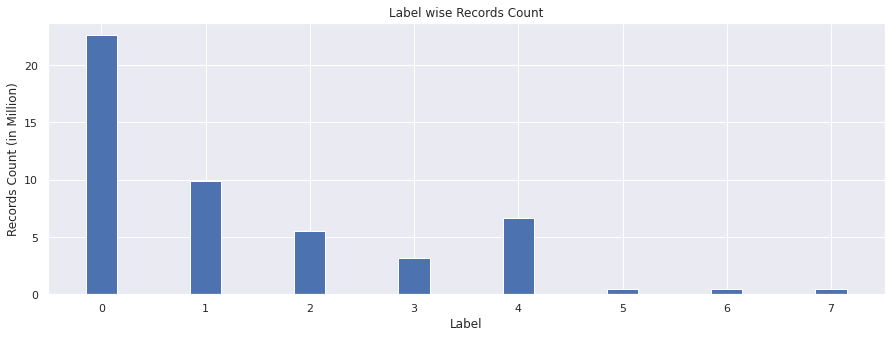

In [11]:
# Plot bar graph for label wise records count: label represents 7 different effective states of a subject
datavis.plot_records_count(x= label_counts.index,y= label_counts/1000000,x_label= "Label",
                           y_label= "Records Count (in Million)",t_title= "Label wise Records Count")

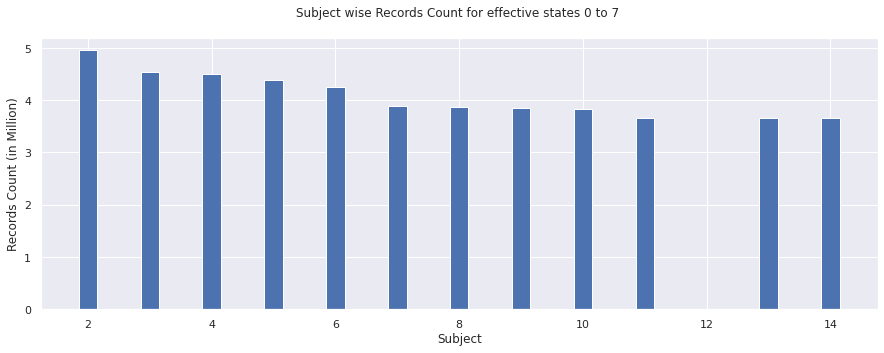

In [19]:
# Plot bar graph for subject wise records count in the raw dataset
subj_count = list(data_raw.subject.value_counts()/1000000)
subj_name = list(data_raw.subject.unique())

datavis.plot_records_count(x= subj_name,y= subj_count,x_label= "Subject",
                           y_label= "Records Count (in Million)",
                           t_title= "Subject wise Records Count for effective states 0 to 7 \n")

###### Drop records for effective states : 0,5,6 & 7
* State-0 : not defined and transient state 
* State-5 to 7: ignored in line with original paper refrered for this work

In [12]:
print('Records count original:',data_raw.shape)
data_raw_filtered = data_raw[(data_raw['label'] < 5) & (data_raw['label'] > 0)]
print('Records count post filtering labels 1 to 4:',data_raw_filtered.shape)

Records count original: (49045500, 56)
Records count post filtering labels 1 to 4: (25137704, 56)


Subjects:S[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14] 
Records Count(in Million):[2.1511, 2.114701, 2.1147, 2.113301, 2.1077, 2.103499, 2.093, 2.0923, 2.091602, 2.079001, 2.054501, 2.022299]


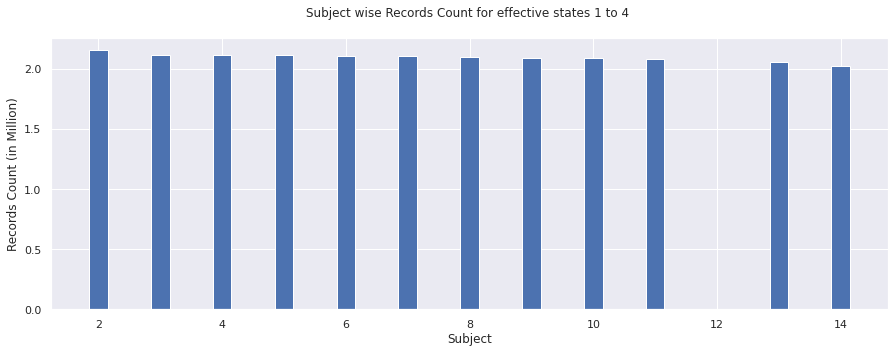

In [13]:
# Records count for each Subject in the training dataset
subj_count = list(data_raw_filtered.subject.value_counts()/1000000)
subj_name = list(data_raw_filtered.subject.unique())
print('Subjects:S{} \nRecords Count(in Million):{}'.format(subj_name,subj_count))

datavis.plot_records_count(x= subj_name,y= subj_count,x_label= "Subject",
                           y_label= "Records Count (in Million)",
                           t_title= "Subject wise Records Count for effective states 1 to 4 \n")

In [14]:
effective_state_label = {'Baseline':1,'Stress':2,'Amusement':3,'Meditation':4}
print(list(effective_state_label.keys()))

['Baseline', 'Stress', 'Amusement', 'Meditation']


### Visual Analysis for Different Affective States for a Subjects for a Specified Sensor Type

##### ACC plot for a Subject

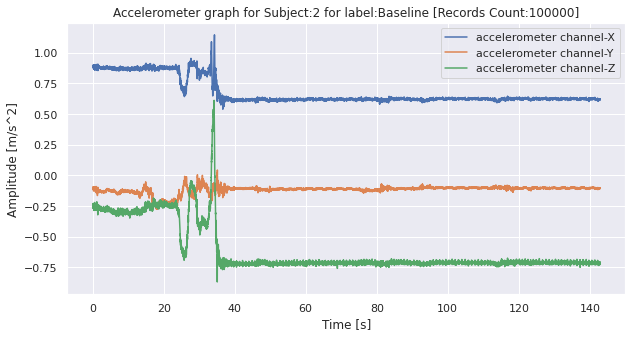

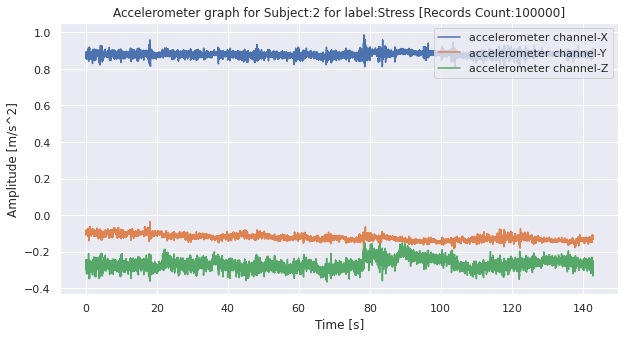

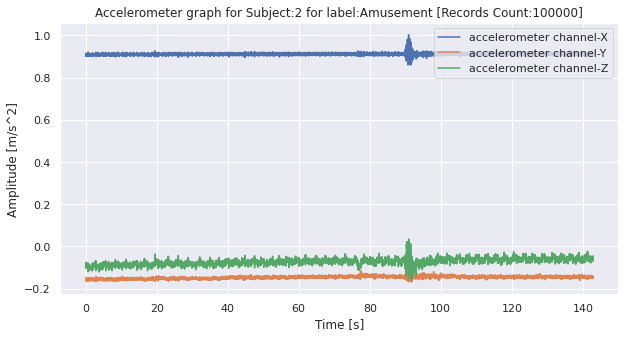

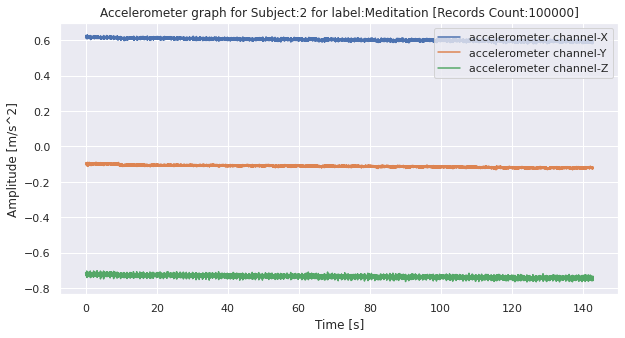

In [15]:
# pass subject number for which graph to be created
datavis.plot_acc_for_subject(dataset=data_raw_filtered,
                             subject= 2,
                             num_of_records = 100000,
                             labels = list(effective_state_label.keys()),
                             first_last = 'first')

#### Sensor Graph for a Subject, e.g. "ECG"

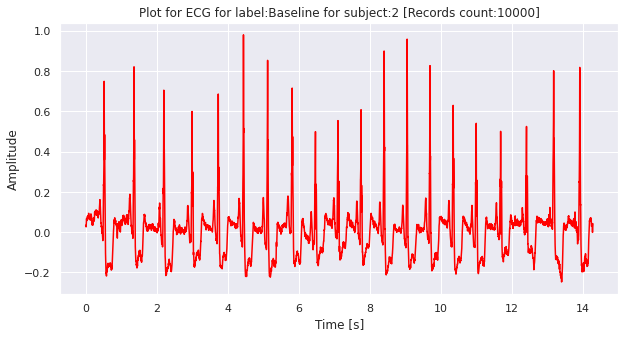

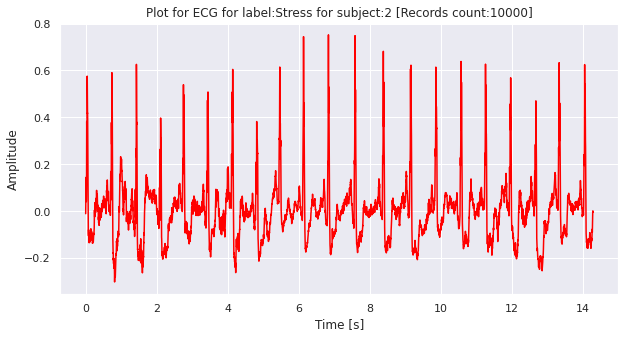

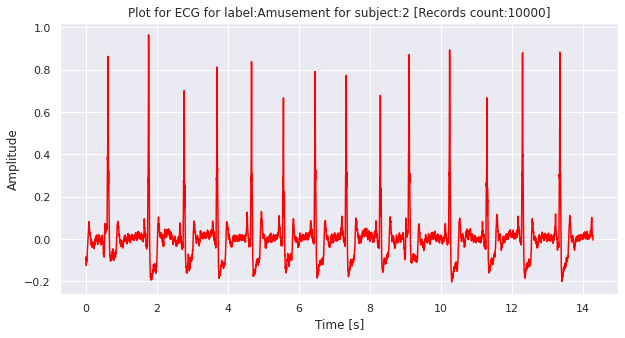

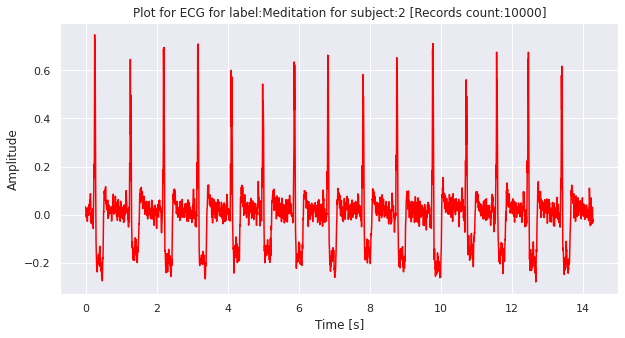

In [16]:
# Create Sensor line graph for a subject                            
datavis.plot_data_for_subject(dataset=data_raw_filtered,
                              subject = 2,
                              num_of_records = 10000,
                              sensor_type = 'ECG',
                              labels = list(effective_state_label.keys()),
                              first_last = 'first'
                              )

##### Data Distribution for different Sensors

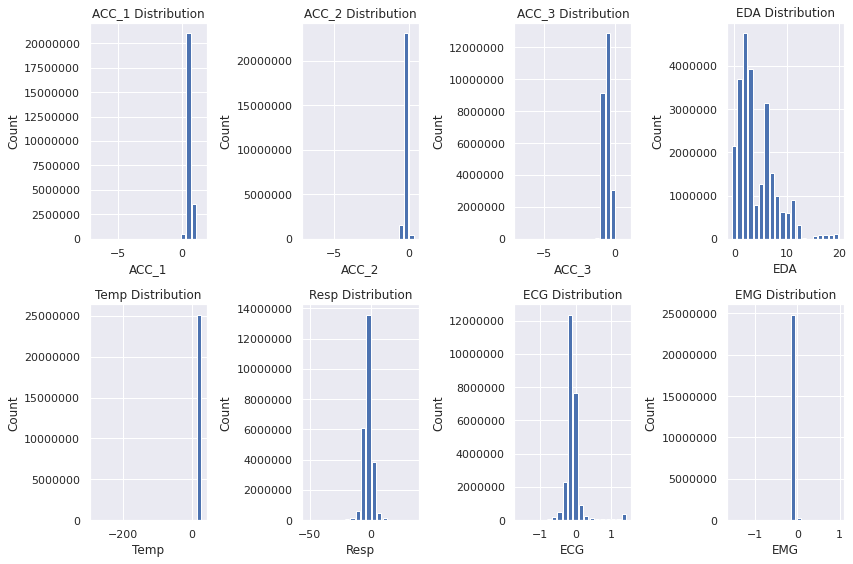

In [17]:
sensor_list = ['ACC_1', 'ACC_2', 'ACC_3','EDA', 'Temp', 'Resp', 'ECG', 'EMG']
datavis.plot_sensor_data(data_raw_filtered,sensor_list)

##### Correlation Analysis

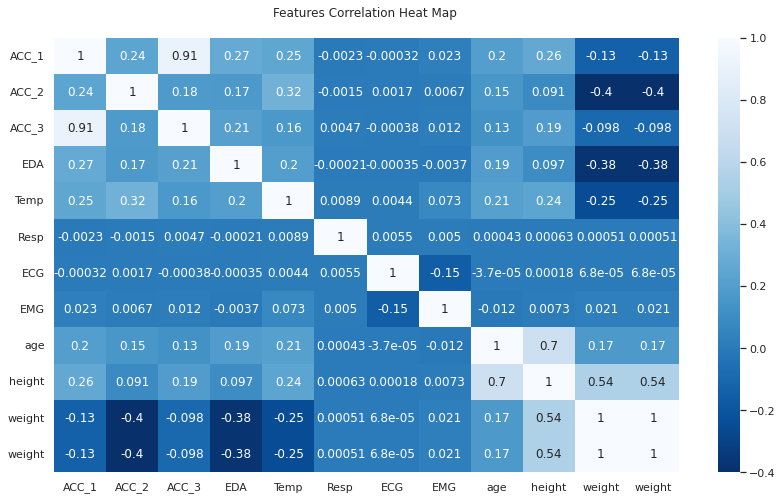

In [18]:
data_corr =  data_raw_filtered[['ACC_1', 'ACC_2', 'ACC_3','EDA', 'Temp', 'Resp', 'ECG', 'EMG','age',
                                'height','weight','weight']]
corr = data_corr.corr()
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap="Blues_r", ax=ax)
plt.title('Features Correlation Heat Map \n')
plt.show()

### Feature Enginnering

In [19]:
# # uncomment and run this code to access the latest modified python file after uploading
# import importlib
# # name of the python file to be imported
# import Capstone_Utilities as utility
# importlib.reload(utility)

##### Down sampling original data from 700 Hz to 50 Hz frequency to reduce the number of records for Analysis

* This step is done due to limitations in the existing infrastructure on Greatlakes (processing approx. 45+ millions of records) and longer processing time required to finish the data processing. 

In [15]:
data_raw_filtered = utility.data_sampling(data_raw_filtered,sample_rate=700,down_sample_freq='50ms')
data_raw_filtered.head()

Shape before down sampling: (25137704, 56)
Shape AFTER resample: (718277, 55)


Unnamed: 0     ACC_1     ACC_2  \
subject label time                                                      
2       1     1970-01-01 00:00:00.000    214600.0  0.889131 -0.104177   
              1970-01-01 00:00:00.050    214635.0  0.889731 -0.100206   
              1970-01-01 00:00:00.100    214670.0  0.893480 -0.103223   
              1970-01-01 00:00:00.150    214705.0  0.878366 -0.113154   
              1970-01-01 00:00:00.200    214740.0  0.890411 -0.117394   

                                          ACC_3       ECG       EMG       EDA  \
subject label time                                                              
2       1     1970-01-01 00:00:00.000 -0.254086  0.052203  0.000302  5.712509   
              1970-01-01 00:00:00.050 -0.242897  0.076138 -0.005188  5.707354   
              1970-01-01 00:00:00.100 -0.248234  0.073135 -0.003722  5.698667   
              1970-01-01 00:00:00.150 -0.236754  0.054067  0.000221  5.692651   
              1970-01-01 00:00:00.200 -0.238989  0.058294 -0.003258  5.685992   

                                            Temp      Resp   age  ...  \
subject label time                                                ...   
2       1     1970-01-01 00:00:00.000  29.119919  1.025521  27.0  ...   
              1970-01-01 00:00:00.050  29.119755  0.710013  27.0  ...   
              1970-01-01 00:00:00.100  29.125584  0.327802  27.0  ...   
              1970-01-01 00:00:00.150  29.133441 -0.066877  27.0  ...   
              1970-01-01 00:00:00.200  29.122919 -0.490505  27.0  ...   

                                       STAI06_PLEASANT  SAM01_VALENCE  \
subject label time                                                      
2       1     1970-01-01 00:00:00.000              3.0            7.0   
              1970-01-01 00:00:00.050              3.0            7.0   
              1970-01-01 00:00:00.100              3.0            7.0   
              1970-01-01 00:00:00.150              3.0            7.0   
              1970-01-01 00:00:00.200              3.0            7.0   

                                       SAM02_AROUSAL  SSQ01_GOALS  \
subject label time                                                  
2       1     1970-01-01 00:00:00.000            2.0          NaN   
              1970-01-01 00:00:00.050            2.0          NaN   
              1970-01-01 00:00:00.100            2.0          NaN   
              1970-01-01 00:00:00.150            2.0          NaN   
              1970-01-01 00:00:00.200            2.0          NaN   

                                       SSQ02_SUCCEED  SSQ03_MOTIVATED  \
subject label time                                                      
2       1     1970-01-01 00:00:00.000            NaN              NaN   
              1970-01-01 00:00:00.050            NaN              NaN   
              1970-01-01 00:00:00.100            NaN              NaN   
              1970-01-01 00:00:00.150            NaN              NaN   
              1970-01-01 00:00:00.200            NaN              NaN   

                                       SSQ04_REFLECTED  SSQ03_THINK  \
subject label time                                                    
2       1     1970-01-01 00:00:00.000              NaN          NaN   
              1970-01-01 00:00:00.050              NaN          NaN   
              1970-01-01 00:00:00.100              NaN          NaN   
              1970-01-01 00:00:00.150              NaN          NaN   
              1970-01-01 00:00:00.200              NaN          NaN   

                                       SSQ03_IMPRESSION   seconds  
subject label time                                                 
2       1     1970-01-01 00:00:00.000               NaN  0.024286  
              1970-01-01 00:00:00.050               NaN  0.074286  
              1970-01-01 00:00:00.100               NaN  0.124286  
              1970-01-01 00:00:00.150               NaN  0.174286  
              1970-01-01 00:00:00

In [16]:
data_raw_filtered = data_raw_filtered.reset_index()
display(data_raw_filtered.head())
features_list = ['ACC_1', 'ACC_2', 'ACC_3', 'ECG', 'EMG', 'EDA','Temp', 'Resp']

,subject,label,time,Unnamed: 0,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,...,STAI06_PLEASANT,SAM01_VALENCE,SAM02_AROUSAL,SSQ01_GOALS,SSQ02_SUCCEED,SSQ03_MOTIVATED,SSQ04_REFLECTED,SSQ03_THINK,SSQ03_IMPRESSION,seconds
0,2,1,1970-01-01 00:00:00.000,214600.0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,...,3.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.024286
1,2,1,1970-01-01 00:00:00.050,214635.0,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,...,3.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.074286
2,2,1,1970-01-01 00:00:00.100,214670.0,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,...,3.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.124286
3,2,1,1970-01-01 00:00:00.150,214705.0,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,...,3.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.174286
4,2,1,1970-01-01 00:00:00.200,214740.0,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,...,3.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.224286


#### Derive stats feature for the sensors

In [17]:
stats_features_dict = {}
stats_features_dict = feature_extraction.get_stats_features(data_raw_filtered,features_list)
print('Stats feature derived:',list(stats_features_dict.keys()))

Stats feature derived: ['ACC_1_mean', 'ACC_1_std', 'ACC_1_min', 'ACC_1_max', 'ACC_2_mean', 'ACC_2_std', 'ACC_2_min', 'ACC_2_max', 'ACC_3_mean', 'ACC_3_std', 'ACC_3_min', 'ACC_3_max', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max', 'EMG_mean', 'EMG_std', 'EMG_min', 'EMG_max', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Resp_mean', 'Resp_std', 'Resp_min', 'Resp_max']


In [18]:
for key,value in list(stats_features_dict.items()):
    data_raw_filtered[key] = value

In [19]:
print('Stats feature added in the raw dataset:',len(list(stats_features_dict.keys())))
print('Dataset shape post adding stats feature:',data_raw_filtered.shape)
data_raw_filtered.head()

Stats feature added in the raw dataset: 32
Dataset shape post adding stats feature: (718277, 90)


,subject,label,time,Unnamed: 0,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,...,EDA_min,EDA_max,Temp_mean,Temp_std,Temp_min,Temp_max,Resp_mean,Resp_std,Resp_min,Resp_max
0,2,1,1970-01-01 00:00:00.000,214600.0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,...,0.0,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807
1,2,1,1970-01-01 00:00:00.050,214635.0,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,...,0.0,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807
2,2,1,1970-01-01 00:00:00.100,214670.0,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,...,0.0,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807
3,2,1,1970-01-01 00:00:00.150,214705.0,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,...,0.0,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807
4,2,1,1970-01-01 00:00:00.200,214740.0,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,...,0.0,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807


#### Derive ACC related features

In [28]:
# data_raw_filtered = data_raw_filtered.reset_index()
acc_df = data_raw_filtered[['ACC_1', 'ACC_2', 'ACC_3']]
print('ACC dataset shape:',acc_df.shape)
data_with_acc_features = feature_extraction.get_acc_features(acc_df)
print('Updated dataset shape:',data_with_acc_features.shape)
data_with_acc_features.head()

ACC dataset shape: (718277, 3)



ACC features to be added: ['l2_mean', 'l2_std', 'l2_min', 'l2_max', 'l2_ptp', 'l2_sum', 'l2_energy', 'l2_peaks', 'l2_rms', 'l2_lineintegral', 'l2_n_above_mean', 'l2_n_below_mean', 'l2_n_sign_changes', 'l2_entropy']
Updated dataset shape: (718277, 17)


,acc_x,acc_y,acc_z,l2_mean,l2_std,l2_min,l2_max,l2_ptp,l2_sum,l2_energy,l2_peaks,l2_rms,l2_lineintegral,l2_n_above_mean,l2_n_below_mean,l2_n_sign_changes,l2_entropy
0,0.889131,-0.104177,-0.254086,0.933292,0.025367,0.487367,11.431535,10.944168,670362.074272,626105.656649,2,0.933637,3686.999267,296947,421330,0,13.484351
1,0.889731,-0.100206,-0.242897,0.933292,0.025367,0.487367,11.431535,10.944168,670362.074272,626105.656649,2,0.933637,3686.999267,296947,421330,0,13.484351
2,0.893480,-0.103223,-0.248234,0.933292,0.025367,0.487367,11.431535,10.944168,670362.074272,626105.656649,2,0.933637,3686.999267,296947,421330,0,13.484351
3,0.878366,-0.113154,-0.236754,0.933292,0.025367,0.487367,11.431535,10.944168,670362.074272,626105.656649,2,0.933637,3686.999267,296947,421330,0,13.484351
4,0.890411,-0.117394,-0.238989,0.933292,0.025367,0.487367,11.431535,10.944168,670362.074272,626105.656649,2,0.933637,3686.999267,296947,421330,0,13.484351


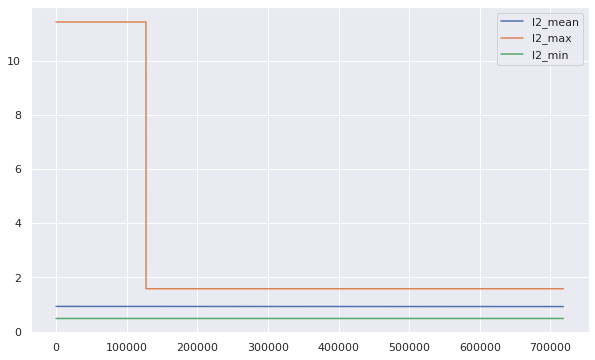

In [29]:
_ = data_with_acc_features[['l2_mean', 'l2_max', 'l2_min']].plot(figsize=(10,6))

###### Save ACC features dataset

In [30]:
data_with_acc_features.columns

Index(['acc_x', 'acc_y', 'acc_z', 'l2_mean', 'l2_std', 'l2_min', 'l2_max',
       'l2_ptp', 'l2_sum', 'l2_energy', 'l2_peaks', 'l2_rms',
       'l2_lineintegral', 'l2_n_above_mean', 'l2_n_below_mean',
       'l2_n_sign_changes', 'l2_entropy'],
      dtype='object')

In [31]:
file_name = 'data_with_acc_features_50ms.csv'
data_with_acc_features.to_csv(file_name)

#### Derive EDA feature

In [32]:
eda_df = data_raw_filtered[['EDA']]
print('efd_df shape',eda_df.shape)

eda_features_data = feature_extraction.get_eda_features(eda_df)
print('Updated dataset shape:',eda_features_data.shape)
eda_features_data.head()

efd_df shape (718277, 1)



EDA features to be added: ['tonic_mean', 'tonic_std', 'tonic_min', 'tonic_max', 'tonic_energy', 'tonic_peaks', 'tonic_rms', 'tonic_entropy', 'phasic_mean', 'phasic_std', 'phasic_min', 'phasic_max', 'phasic_energy', 'phasic_peaks', 'phasic_rms', 'phasic_entropy']
Updated dataset shape: (718277, 17)


,EDA,tonic_mean,tonic_std,tonic_min,tonic_max,tonic_energy,tonic_peaks,tonic_rms,tonic_entropy,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,phasic_entropy
0,5.712509,-2.16241,11.898271,-73.667251,15.821124,1.050443e+08,27.0,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
1,5.707354,-2.16241,11.898271,-73.667251,15.821124,1.050443e+08,27.0,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
2,5.698667,-2.16241,11.898271,-73.667251,15.821124,1.050443e+08,27.0,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
3,5.692651,-2.16241,11.898271,-73.667251,15.821124,1.050443e+08,27.0,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
4,5.685992,-2.16241,11.898271,-73.667251,15.821124,1.050443e+08,27.0,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029


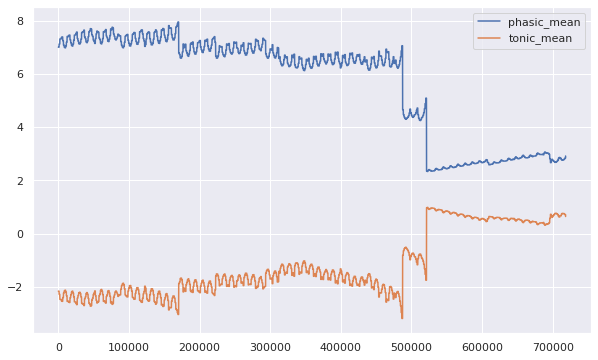

In [33]:
_ = eda_features_data[['phasic_mean', 'tonic_mean']].plot(figsize=(10,6))

##### Save EDA dataset with features

In [35]:
file_name = 'data_with_eda_features_50ms.csv'
eda_features_data.to_csv(file_name)

### Add frequency column from ECG - finds peaks of ECG raw signal

In [20]:
##### add frequency column from ECG

#####################################################################
### add frequency feature here (PL - custom column / feature):
var_increment = 5000
var_ECG_frequency = feature_extraction.get_ECG_feature_column(data_raw_filtered["ECG"], var_increment)
var_frequency_df = var_ECG_frequency[0]

data_raw_filtered["ECG_freq"] = var_frequency_df["ECG_freq"]
# print(data_raw.dtypes)

print('original dataset with ECG Freq shape:',data_raw_filtered.shape)
display(data_raw_filtered.head())

original dataset with ECG Freq shape: (718277, 91)


,subject,label,time,Unnamed: 0,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,...,EDA_max,Temp_mean,Temp_std,Temp_min,Temp_max,Resp_mean,Resp_std,Resp_min,Resp_max,ECG_freq
0,2,1,1970-01-01 00:00:00.000,214600.0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,...,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807,15.0
1,2,1,1970-01-01 00:00:00.050,214635.0,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,...,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807,15.0
2,2,1,1970-01-01 00:00:00.100,214670.0,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,...,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807,15.0
3,2,1,1970-01-01 00:00:00.150,214705.0,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,...,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807,15.0
4,2,1,1970-01-01 00:00:00.200,214740.0,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,...,20.364336,33.857539,1.452812,-273.15,35.652885,0.049622,3.750778,-50.0,37.63807,15.0


##### Extract additional EDA Features
* Derive additional EDA features

In [21]:
eda_signal = data_raw_filtered['EDA']
eda_features_dict = feature_extraction.eda_features(eda_signal)
print(eda_features_dict)
# Add EDA features in the main dataset
for key,value in eda_features_dict.items():
    data_raw_filtered[key] = value
# print('EDA feature added in the raw dataset:',list(data_raw.columns))
print('Dataset dimension post adding EDA feature:',data_raw_filtered.shape)
# data_raw_filtered = data_raw_filtered.reset_index()
data_raw_filtered.head()

{'eda_amp_mean': nan, 'eda_amp_std': nan, 'eda_rise_mean': 319545.0209309791, 'eda_rise_std': 204741.51708906353, 'eda_recovery_mean': -338341.0944511668, 'eda_recovery_std': 228463.1666478904, 'eda_scr_num': 202475, 'eda_scr_freq': 197.32289910438453}
Dataset dimension post adding EDA feature: (718277, 99)


,subject,label,time,Unnamed: 0,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,...,Resp_max,ECG_freq,eda_amp_mean,eda_amp_std,eda_rise_mean,eda_rise_std,eda_recovery_mean,eda_recovery_std,eda_scr_num,eda_scr_freq
0,2,1,1970-01-01 00:00:00.000,214600.0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,...,37.63807,15.0,NaN,NaN,319545.020931,204741.517089,-338341.094451,228463.166648,202475,197.322899
1,2,1,1970-01-01 00:00:00.050,214635.0,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,...,37.63807,15.0,NaN,NaN,319545.020931,204741.517089,-338341.094451,228463.166648,202475,197.322899
2,2,1,1970-01-01 00:00:00.100,214670.0,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,...,37.63807,15.0,NaN,NaN,319545.020931,204741.517089,-338341.094451,228463.166648,202475,197.322899
3,2,1,1970-01-01 00:00:00.150,214705.0,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,...,37.63807,15.0,NaN,NaN,319545.020931,204741.517089,-338341.094451,228463.166648,202475,197.322899
4,2,1,1970-01-01 00:00:00.200,214740.0,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,...,37.63807,15.0,NaN,NaN,319545.020931,204741.517089,-338341.094451,228463.166648,202475,197.322899


##### Derive EMG Features

In [22]:
emg_data = data_raw_filtered['EMG'].to_numpy()# load EMG data from WESAD dataset
sampling_rate = 700 # sampling rate of EMG data
emg_features_dict = feature_extraction.extract_emg_features(emg_data, sampling_rate)
print(emg_features_dict)

Setting up band-pass filter from 10 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 325.00 Hz)
- Filter length: 925 samples (1.321 sec)

{'variance': 8.160149136508401e-06, 'rms': 0.0028565974754535804, 'wl': 1281.4139345995186, 'zc': 411413.0, 'mav': 0.0011320304244767287}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [23]:
# Add features in the dataset
for key,value in list(emg_features_dict.items()):
    data_raw_filtered[key] = value
print('EMG feature added in the raw dataset:',len(list(emg_features_dict.keys())))
print('Dataset shape post adding EMG feature:',data_raw_filtered.shape)
data_raw_filtered.head()

EMG feature added in the raw dataset: 5
Dataset shape post adding EMG feature: (718277, 104)


,subject,label,time,Unnamed: 0,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,...,eda_rise_std,eda_recovery_mean,eda_recovery_std,eda_scr_num,eda_scr_freq,variance,rms,wl,zc,mav
0,2,1,1970-01-01 00:00:00.000,214600.0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,...,204741.517089,-338341.094451,228463.166648,202475,197.322899,0.000008,0.002857,1281.413935,411413.0,0.001132
1,2,1,1970-01-01 00:00:00.050,214635.0,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,...,204741.517089,-338341.094451,228463.166648,202475,197.322899,0.000008,0.002857,1281.413935,411413.0,0.001132
2,2,1,1970-01-01 00:00:00.100,214670.0,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,...,204741.517089,-338341.094451,228463.166648,202475,197.322899,0.000008,0.002857,1281.413935,411413.0,0.001132
3,2,1,1970-01-01 00:00:00.150,214705.0,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,...,204741.517089,-338341.094451,228463.166648,202475,197.322899,0.000008,0.002857,1281.413935,411413.0,0.001132
4,2,1,1970-01-01 00:00:00.200,214740.0,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,...,204741.517089,-338341.094451,228463.166648,202475,197.322899,0.000008,0.002857,1281.413935,411413.0,0.001132


In [25]:
file_name = 'data_raw_filtered_50ms.csv'
data_raw_filtered.to_csv(file_name)

#### Combine all features for final dataset for Machine Learning

In [59]:
# load dataset from files:

# load acc data
data_with_acc_features = pd.read_csv('data_with_acc_features_50ms.csv')
print('ACC feature dataset:',data_with_acc_features.shape)
print('ACC features:\n',data_with_acc_features.columns)

#load EDA dataset
eda_features_data = pd.read_csv('data_with_eda_features_50ms.csv')
# rename EDA column to EDA_1
eda_features_data = eda_features_data.rename(columns={'EDA': 'EDA_1'})
print('EDA features dataset:',eda_features_data.shape)

print('EDA features:\n',eda_features_data.columns)

# print('EDA dataset attributes:\n',eda_features_data.columns)
data_raw = pd.read_csv('data_raw_filtered_50ms.csv')
print('Original Dataset with added features shape:',data_raw.shape)
print('data_raw features:\n',list(data_raw.columns))

ACC feature dataset: (718277, 18)
ACC features:
 Index(['Unnamed: 0', 'acc_x', 'acc_y', 'acc_z', 'l2_mean', 'l2_std', 'l2_min',
       'l2_max', 'l2_ptp', 'l2_sum', 'l2_energy', 'l2_peaks', 'l2_rms',
       'l2_lineintegral', 'l2_n_above_mean', 'l2_n_below_mean',
       'l2_n_sign_changes', 'l2_entropy'],
      dtype='object')
EDA features dataset: (718277, 18)
EDA features:
 Index(['Unnamed: 0', 'EDA_1', 'tonic_mean', 'tonic_std', 'tonic_min',
       'tonic_max', 'tonic_energy', 'tonic_peaks', 'tonic_rms',
       'tonic_entropy', 'phasic_mean', 'phasic_std', 'phasic_min',
       'phasic_max', 'phasic_energy', 'phasic_peaks', 'phasic_rms',
       'phasic_entropy'],
      dtype='object')
Original Dataset with added features shape: (718277, 105)
data_raw features:
 ['Unnamed: 0', 'subject', 'label', 'time', 'Unnamed: 0.1', 'ACC_1', 'ACC_2', 'ACC_3', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'age', 'height', 'weight', 'gender', 'dominant_hand', 'PANAS01_Active', 'PANAS02_Distressed', 'PANAS03_

In [61]:
##### Concatenate dataset
df_dataset = pd.concat([data_raw,data_with_acc_features,eda_features_data],axis=1)
print('final dataset:',df_dataset.shape)
df_dataset.head()

final dataset: (718277, 141)


,Unnamed: 0,subject,label,time,Unnamed: 0.1,ACC_1,ACC_2,ACC_3,ECG,EMG,...,tonic_rms,tonic_entropy,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,phasic_entropy
0,0,2,1,1970-01-01 00:00:00.000,214600.0,0.889131,-0.104177,-0.254086,0.052203,0.000302,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
1,1,2,1,1970-01-01 00:00:00.050,214635.0,0.889731,-0.100206,-0.242897,0.076138,-0.005188,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
2,2,2,1,1970-01-01 00:00:00.100,214670.0,0.893480,-0.103223,-0.248234,0.073135,-0.003722,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
3,3,2,1,1970-01-01 00:00:00.150,214705.0,0.878366,-0.113154,-0.236754,0.054067,0.000221,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
4,4,2,1,1970-01-01 00:00:00.200,214740.0,0.890411,-0.117394,-0.238989,0.058294,-0.003258,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029


In [62]:
print(list(df_dataset.columns))

['Unnamed: 0', 'subject', 'label', 'time', 'Unnamed: 0.1', 'ACC_1', 'ACC_2', 'ACC_3', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'age', 'height', 'weight', 'gender', 'dominant_hand', 'PANAS01_Active', 'PANAS02_Distressed', 'PANAS03_Interested', 'PANAS04_Inspired', 'PANAS05_Annoyed', 'PANAS06_Strong', 'PANAS07_Guilty', 'PANAS08_Scared', 'PANAS09_Hostile', 'PANAS10_Excited', 'PANAS11_Proud', 'PANAS12_Irritable', 'PANAS13_Enthusiastic', 'PANAS14_Ashamed', 'PANAS15_Alert', 'PANAS16_Nervous', 'PANAS17_Determined', 'PANAS18_Attentive', 'PANAS19_Jittery', 'PANAS20_Afraid', 'PANAS21_Stressed', 'PANAS22_Frustrated', 'PANAS23_Happy', 'PANAS24_Angry', 'PANAS25_Irritated', 'PANAS26_Sad', 'STAI01_FEEL', 'STAI02_NERVOUS', 'STAI03_JITTERY', 'STAI04_RELAXED', 'STAI05_WORRIED', 'STAI06_PLEASANT', 'SAM01_VALENCE', 'SAM02_AROUSAL', 'SSQ01_GOALS', 'SSQ02_SUCCEED', 'SSQ03_MOTIVATED', 'SSQ04_REFLECTED', 'SSQ03_THINK', 'SSQ03_IMPRESSION', 'seconds', 'ACC_1_mean', 'ACC_1_std', 'ACC_1_min', 'ACC_1_max', 'ACC_2_mean'

##### Format Data: Drop NaN,Inf, duplicate etc. in the dataset

In [63]:
df_dataset_for_ml = utility.Format_Data(df_dataset)
print(df_dataset_for_ml.shape)
print(list(df_dataset_for_ml.columns))

(718277, 87)
['ACC_1', 'ACC_2', 'ACC_3', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'age', 'height', 'weight', 'gender', 'dominant_hand', 'seconds', 'ACC_1_mean', 'ACC_1_std', 'ACC_1_min', 'ACC_1_max', 'ACC_2_mean', 'ACC_2_std', 'ACC_2_min', 'ACC_2_max', 'ACC_3_mean', 'ACC_3_std', 'ACC_3_min', 'ACC_3_max', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max', 'EMG_mean', 'EMG_std', 'EMG_min', 'EMG_max', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Resp_mean', 'Resp_std', 'Resp_min', 'Resp_max', 'ECG_freq', 'eda_rise_mean', 'eda_rise_std', 'eda_recovery_mean', 'eda_recovery_std', 'eda_scr_num', 'eda_scr_freq', 'variance', 'rms', 'wl', 'zc', 'mav', 'l2_mean', 'l2_std', 'l2_min', 'l2_max', 'l2_ptp', 'l2_sum', 'l2_energy', 'l2_peaks', 'l2_rms', 'l2_lineintegral', 'l2_n_above_mean', 'l2_n_below_mean', 'l2_n_sign_changes', 'l2_entropy', 'tonic_mean', 'tonic_std', 'tonic_min', 'tonic_max', 'tonic_energy', 'tonic_peaks', 'tonic_rms', 'phasic_mean', 'phasic_st

##### Save final Dataset for ML work

In [64]:
df_dataset_for_ml.to_csv('Capstone_final_dataset_for_ml_50ms.csv')

In [65]:
df_final = pd.read_csv('Capstone_final_dataset_for_ml_50ms.csv')
df_final.shape

(718277, 88)

In [66]:
df_final.head()

,Unnamed: 0,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,...,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,label
0,0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
1,1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
2,2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
3,3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
4,4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
